In [2]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

In [3]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "harshasurampudi/gptj-lfqa-without-reasoning1"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=True)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6b")


# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

ValueError: Can't find 'adapter_config.json' at 'harshasurampudi/gptj-lfqa-without-reasoning1'

In [43]:
tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = 'left'

In [7]:
import pandas as pd
df = pd.read_csv('../data/extracted/test.csv')
df.head()

,Context,Question,Legal Reasoning,Answer
0,and Statistical Manual of Mental Disorders 446...,Can the defendants force Dr. Nadel to provide ...,The issue at hand pertains to the compulsion o...,"No, according to the Graham v. Gielchinsky cas..."
1,"one of his trial counsel as a witness, so the ...",Did the Appellee's trial counsel have knowledg...,The question at hand pertains to the knowledge...,It is uncertain whether the Appellee's trial c...
2,Some of Cruikshank’s objections on appeal appe...,Can Cruikshank's objections on the trial court...,The issue at hand pertains to the admissibilit...,"No, Cruikshank's objections on the trial court..."
3,noting that the additional materials provided ...,Can the motion to strike filed by PFM be consi...,The question pertains to the categorization of...,"Yes, the motion to strike filed by PFM can be ..."
4,The State is within the powers reserved to it ...,Can the State refuse to enter into agreements ...,The question revolves around the State's power...,"Yes, the State has the power to refuse to ente..."


In [10]:
df['Prompt'] = df.apply(lambda row: f"""Context:
{row['Context']}
Question:
{row['Question']}
Answer:
""", axis=1)

df['Prompt'].to_list()

,Context,Question,Legal Reasoning,Answer,Prompt
0,and Statistical Manual of Mental Disorders 446...,Can the defendants force Dr. Nadel to provide ...,The issue at hand pertains to the compulsion o...,"No, according to the Graham v. Gielchinsky cas...",Context:\nand Statistical Manual of Mental Dis...
1,"one of his trial counsel as a witness, so the ...",Did the Appellee's trial counsel have knowledg...,The question at hand pertains to the knowledge...,It is uncertain whether the Appellee's trial c...,Context:\none of his trial counsel as a witnes...
2,Some of Cruikshank’s objections on appeal appe...,Can Cruikshank's objections on the trial court...,The issue at hand pertains to the admissibilit...,"No, Cruikshank's objections on the trial court...",Context:\nSome of Cruikshank’s objections on a...
3,noting that the additional materials provided ...,Can the motion to strike filed by PFM be consi...,The question pertains to the categorization of...,"Yes, the motion to strike filed by PFM can be ...",Context:\nnoting that the additional materials...
4,The State is within the powers reserved to it ...,Can the State refuse to enter into agreements ...,The question revolves around the State's power...,"Yes, the State has the power to refuse to ente...",Context:\nThe State is within the powers reser...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


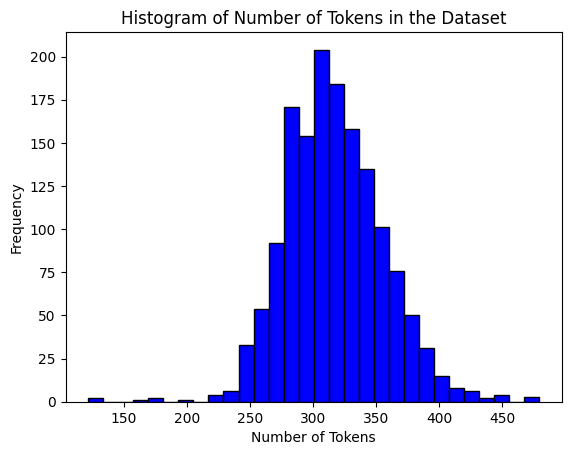

In [22]:
import matplotlib.pyplot as plt
# Generate the expected strings and tokenize them
expected_strings = df.apply(lambda row: f"""
Context:
{row['Context']}
Question:
{row['Question']}
Answer:
{row['Answer']}""", axis=1)
token_counts = [len(tokenizer.encode(s)) for s in expected_strings]

# Plot the histogram
plt.hist(token_counts, bins=30, color='blue', edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens in the Dataset')
plt.show()

In [48]:
def generate_answers(batch, model, tokenizer, max_length=450):
    with torch.no_grad():
        input_ids = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)['input_ids']
        outputs = model.generate(input_ids=input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id, temperature=0.7)
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

In [ ]:
from tqdm import tqdm
batch_size = 16
results_without_reasoning = []
for i in tqdm(range(0, len(df), batch_size), desc='Generating without reasoning'):
    batch = df['Prompt'][i:i+batch_size].tolist()
    results = generate_answers(batch, model, tokenizer)
    print(results)
    results_without_reasoning.extend(results)

In [3]:
inp_text ="""Context:
Stat. § 14-32.1(a), does not make the definition an essential element of the crime pursuant to N.C. Gen. Stat. § 14-32.1(e). Therefore, we reject Defendant’s argument that it is not sufficient for the indictment to “merely state that the victim was ‘handicapped.’ ” Furthermore, the indictment provided Defendant with enough information to prepare a defense for the offense of felony assault on a handicapped person. See Leonard, _ N.C. App. at _, 711 S.E.2d at 873 (rejecting the defendant’s argument that the indictment was not sufficient because the indictment tracked the relevant language of the statute, listed “the essential elements of the offense[,]” and provided the defendant “with enough information to prepare a defense”); State v. Crisp, 126 N.C. App. 30, 36, 483 S.E.2d 462, 466 (<HOLDING>), appeal dismissed and disc. review denied, 346
Question: Is it necessary for the definition of the crime to be stated in the indictment according to N.C. Gen. Stat. § 14-32.1(a)?
Answer:
"""
batch = tokenizer(inp_text, return_tensors='pt')

# Move batch to CUDA
batch = {k: v.to('cuda') for k, v in batch.items()}

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=1000, temperature=0.7)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

/usr/local/lib/python3.9/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.9/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")




 Context:
Stat. § 14-32.1(a), does not make the definition an essential element of the crime pursuant to N.C. Gen. Stat. § 14-32.1(e). Therefore, we reject Defendant’s argument that it is not sufficient for the indictment to “merely state that the victim was ‘handicapped.’ ” Furthermore, the indictment provided Defendant with enough information to prepare a defense for the offense of felony assault on a handicapped person. See Leonard, _ N.C. App. at _, 711 S.E.2d at 873 (rejecting the defendant’s argument that the indictment was not sufficient because the indictment tracked the relevant language of the statute, listed “the essential elements of the offense[,]” and provided the defendant “with enough information to prepare a defense”); State v. Crisp, 126 N.C. App. 30, 36, 483 S.E.2d 462, 466 (<HOLDING>), appeal dismissed and disc. review denied, 346
Question: Is it necessary for the definition of the crime to be stated in the indictment according to N.C. Gen. Stat. § 14-32.1(a)?
Ans

In [ ]:
results_without_reasoning

In [53]:
from transformers import pipeline, GenerationConfig

In [5]:
!ls

README.md	      quick_start_pytorch.ipynb
legal-reasoning-lfqa  quick_start_pytorch_images


In [9]:
from huggingface_hub import login
login()

In [2]:
from peft_pipe import peft_pipeline

In [3]:
 pipe = peft_pipeline(
    base_model_name="EleutherAI/gpt-j-6b",
    lora_model_name="harshasurampudi/gptj-lfqa-without-reasoning1",
     temperature=0.7
    )

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead',

In [4]:
inp_text ="""Context:
Stat. § 14-32.1(a), does not make the definition an essential element of the crime pursuant to N.C. Gen. Stat. § 14-32.1(e). Therefore, we reject Defendant’s argument that it is not sufficient for the indictment to “merely state that the victim was ‘handicapped.’ ” Furthermore, the indictment provided Defendant with enough information to prepare a defense for the offense of felony assault on a handicapped person. See Leonard, _ N.C. App. at _, 711 S.E.2d at 873 (rejecting the defendant’s argument that the indictment was not sufficient because the indictment tracked the relevant language of the statute, listed “the essential elements of the offense[,]” and provided the defendant “with enough information to prepare a defense”); State v. Crisp, 126 N.C. App. 30, 36, 483 S.E.2d 462, 466 (<HOLDING>), appeal dismissed and disc. review denied, 346
Question: Is it necessary for the definition of the crime to be stated in the indictment according to N.C. Gen. Stat. § 14-32.1(a)?
Answer:
"""
pipe(inp_text)

ValueError: If `eos_token_id` is defined, make sure that `pad_token_id` is defined.

In [1]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "harshasurampudi/gptj-lfqa-without-reasoning1"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6b")


# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

In [24]:
from transformers import pipeline, GenerationConfig
config = GenerationConfig(
        do_sample=True,
        temperature=0.7,
        max_new_tokens=150,
        top_p=1,
        pad_token_id=tokenizer.eos_token_id
    )

In [25]:
from transformers import pipeline

model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
model.config.bos_token_id = 1
model.config.eos_token_id = 2

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer,generation_config=config)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead',

In [26]:
inp_text ="""Context:
Stat. § 14-32.1(a), does not make the definition an essential element of the crime pursuant to N.C. Gen. Stat. § 14-32.1(e). Therefore, we reject Defendant’s argument that it is not sufficient for the indictment to “merely state that the victim was ‘handicapped.’ ” Furthermore, the indictment provided Defendant with enough information to prepare a defense for the offense of felony assault on a handicapped person. See Leonard, _ N.C. App. at _, 711 S.E.2d at 873 (rejecting the defendant’s argument that the indictment was not sufficient because the indictment tracked the relevant language of the statute, listed “the essential elements of the offense[,]” and provided the defendant “with enough information to prepare a defense”); State v. Crisp, 126 N.C. App. 30, 36, 483 S.E.2d 462, 466 (<HOLDING>), appeal dismissed and disc. review denied, 346
Question: Is it necessary for the definition of the crime to be stated in the indictment according to N.C. Gen. Stat. § 14-32.1(a)?
Answer:
"""
pipe(inp_text)

[{'generated_text': 'Context:\nStat. § 14-32.1(a), does not make the definition an essential element of the crime pursuant to N.C. Gen. Stat. § 14-32.1(e). Therefore, we reject Defendant’s argument that it is not sufficient for the indictment to “merely state that the victim was ‘handicapped.’ ” Furthermore, the indictment provided Defendant with enough information to prepare a defense for the offense of felony assault on a handicapped person. See Leonard, _ N.C. App. at _, 711 S.E.2d at 873 (rejecting the defendant’s argument that the indictment was not sufficient because the indictment tracked the relevant language of the statute, listed “the essential elements of the offense[,]” and provided the defendant “with enough information to prepare a defense”); State v. Crisp, 126 N.C. App. 30, 36, 483 S.E.2d 462, 466 (<HOLDING>), appeal dismissed and disc. review denied, 346\nQuestion: Is it necessary for the definition of the crime to be stated in the indictment according to N.C. Gen. Sta

In [ ]:
i=0
from transformers.pipelines.pt_utils import KeyDataset
for out in pipe(KeyDataset(test_dataset, "Prompt")):
    df.loc[i, 'Generated Text'] = out[0]['generated_text']
    df.to_csv('test_generated.csv', index=False)
    i+=1
    print(i, end='\r')

i=0
from transformers.pipelines.pt_utils import KeyDataset
for out in pipe(KeyDataset(test_dataset, "Prompt")):
    df.loc[i, 'Generated Text'] = out[0]['generated_text']
    df.to_csv('test_generated.csv', index=False)
    i+=1
    print(i)